# 实验六

使用python实现DPCM编码，对一张灰度图片进行编码和解码，比较不同量化器重建图像区别，并计算PSNR和SSIM。

In [30]:
import cv2
import numpy as np
import io
import matplotlib.pyplot as plt
import skimage
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM


In [31]:

img = cv2.imread('greygraph.png')
h, w = img.shape[:2]  # 高，宽

yvu = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
y, v, u = cv2.split(yvu)

u = cv2.resize(u, (u.shape[1] // 2, u.shape[0] // 2))
v = cv2.resize(v, (v.shape[1] // 2, v.shape[0] // 2))

f = io.BytesIO()

f.write(y.tobytes())
f.write(u.tobytes())
f.write(v.tobytes())
f.seek(0)

img_np = np.frombuffer(f.read(), np.uint8)

img_yuv_len = img_np.size
img_y_len = h * w

y = img_np[:img_y_len]
u = img_np[img_y_len:(img_yuv_len - img_y_len) //
           2 + img_y_len]
v = img_np[(img_yuv_len - img_y_len) // 2 + img_y_len:]

img_re = np.zeros(img_y_len, np.uint16)
yprebuff = np.zeros(img_y_len, np.uint16)

# radio = 512/(1 << 1)
# radio = 512/(1 << 2)
# radio = 512/(1 << 4)
radio = 512/(1 << 8)  # 量化因子，8bit量化
# radio = 512/(1 << 16)

for i in range(h):
    for j in range(w):
        # 左向预测8bit量化
        if j == 0:
            # 每行第一个像素要进行特殊处理，或保留或进行一定预测
            ypre = y[j + i * w]-128  # 计算预测误差
            yprebuff[j + i * w] = (ypre+255)/radio
            img_re[j + i * w] = (yprebuff[j + i * w]-255 /
                                 radio)*radio+128
            if img_re[j + i * w] > 255:
                img_re[j + i * w] = 255
            yprebuff[j + i * w] = yprebuff[j + i * w]*radio/2

        else:
            ypre = y[j + i * w] - img_re[j + i * w - 1]  # 计算预测误差
            yprebuff[j + i * w] = (ypre+255) / radio  # 量化
            img_re[j + i * w] = (yprebuff[j + i * w]-255/radio) * \
                radio+img_re[j + i * w - 1]  # 反量化
            yprebuff[j + i * w] = yprebuff[j + i * w] * radio / 2  # 预测器
            if img_re[j + i * w] > 255:
                img_re[j + i * w] = 255
img_re = img_re.astype(np.uint8)
yprebuff = yprebuff.astype(np.uint8)  # 预测误差

y = y.reshape((h, w))
yprebuff = yprebuff.reshape((h, w))

img_re = img_re.reshape((h, w))

u = u.reshape((h//2, w//2))
v = v.reshape((h//2, w//2))
ru = cv2.resize(u, (w, h))
rv = cv2.resize(v, (w, h))

yvu = cv2.merge((y, rv, ru))
bgr = cv2.cvtColor(yvu, cv2.COLOR_YCrCb2BGR)

yvu_pre = cv2.merge((yprebuff, rv, ru))
bgr_pre = cv2.cvtColor(yvu_pre, cv2.COLOR_YCrCb2BGR)

yvu_re = cv2.merge((img_re, rv, ru))
bgr_re = cv2.cvtColor(yvu_re, cv2.COLOR_YCrCb2BGR)


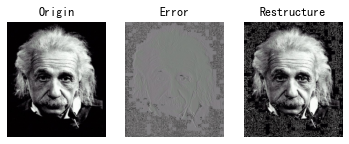

In [32]:

plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),
plt.title('Origin')
plt.axis('off')
plt.subplot(132), plt.imshow(cv2.cvtColor(bgr_pre, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title('Error')
plt.axis('off')
plt.subplot(133), plt.imshow(cv2.cvtColor(bgr_re, cv2.COLOR_BGR2RGB), cmap='gray'),
plt.title('Restructure')
plt.axis('off')

plt.show()


In [38]:
print(PSNR(img, bgr_re))
print(SSIM(img, bgr_re, multichannel=True))

11.984431557213359
0.6106308135302133


C:\Users\admin\AppData\Local\Temp\ipykernel_23140\3352736055.py:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  print(SSIM(img, bgr_re, multichannel=True))
